In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/gono-unitigs/cfx_sr_gwas_filtered_unitigs.Rtab
/kaggle/input/gono-unitigs/cip_sr_gwas_filtered_unitigs.Rtab
/kaggle/input/gono-unitigs/azm_sr_gwas_filtered_unitigs.Rtab
/kaggle/input/gono-unitigs/metadata.csv


In [8]:
#import library
import os
import keras
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import seaborn as sb
import time

from keras.models import Sequential 
from keras.layers import Flatten,Dense,Dropout,Embedding,LSTM
from keras import regularizers,layers,preprocessing 
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score,f1_score
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,average_precision_score
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences




* # Preparing the Dataset

In [17]:
def prep_data(phenotype):
    pheno = pd.read_csv('../input/gono-unitigs/metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype])
    pheno = pheno[phenotype]
    

# read in unitig data
    X = pd.read_csv('../input/gono-unitigs/' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] 
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno

In [31]:
phenotype = 'azm_sr'
X, pheno = prep_data(phenotype)
performance = []
method = []
times = []

#### look at the length distribution of the unitigs in our dataset

Index(['CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG',
       'TACCGTAACCGGCAATGCGGATATTACGGTC', 'CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG',
       'AACGGGTTTTCAGACGGCATTCGATATCGGGACG',
       'CCAAAAATTACCCGCGTTGACGTAGCTAAAGA',
       'CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC',
       'TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG',
       'TACGGTATTGTCCGCATTATTAAACTCAAAACC,AGAAGACGGCATACGAGATGGACAATTTCATCC',
       'GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC',
       'TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC'],
      dtype='object', name='pattern_id')


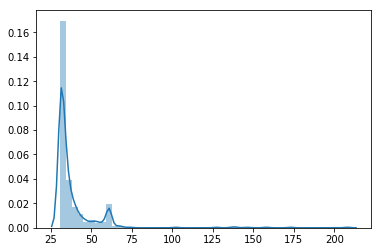

In [32]:
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

#### Model training

In [33]:
# function for fitting a model
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)
        y_pred[y_pred<0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times
    

#### fitting the model to Elastic net logistic regression

In [34]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)


Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[534  16]
 [ 33 113]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[687   1]
 [  1   7]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[648   1]
 [ 31  16]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[593  32]
 [ 15  55]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[503  16]
 [ 23 153]]


#### Support Vector Machine

In [37]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}
svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[687   1]
 [  0   8]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[638  11]
 [  2  45]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


# Fitting the model to XGBoost


In [38]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4],
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2], 
    'objective': ['binary:hinge'],
    'subsample': [0.2, 0.4, 0.6]
    
}
xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[536  14]
 [ 15 131]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[686   2]
 [  0   8]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[636  13]
 [  2  45]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 

# Fitting the model to random forest

In [39]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 412, 'n_estimators': 50}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[681   7]
 [  0   8]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[637  12]
 [  2  45]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[588  37]
 [  5  65]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


In [ ]:
# compare results from the different predictors
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right')